In [1]:
import os
import cv2
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import webbrowser
import subprocess

#Color analysis for a single image:
# Face detection function using OpenCV Haar Cascade
def detect_faces(image_path):
    """Detect faces in an image using OpenCV's Haar Cascade"""
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    return faces, image

def mask_faces(image, faces):
    """Mask the detected faces in the image"""
    mask = np.ones(image.shape[:2], dtype=np.uint8) * 255  # Create a white mask (all areas are kept)
    
    for (x, y, w, h) in faces:
        mask[y:y+h, x:x+w] = 0  # Set the face region to black (to exclude it from color analysis)
    
    masked_image = cv2.bitwise_and(image, image, mask=mask)  # Apply the mask to the image
    return masked_image

def remove_background_pixels(image):
    """Remove black background and isolate garment."""
    if image.shape[2] == 4:  # If image has an alpha channel (RGBA)
        mask = image[:, :, 3] > 0  # Only keep non-transparent pixels
    else:
        # Remove pure black background (thresholding)
        mask = np.any(image[:, :, :3] > 10, axis=-1)  # Avoid pure black (RGB < 10)

    return image[mask]  # Return only pixels inside mask

def extract_colors(image_path, num_colors=5):
    """Extract dominant colors from a garment, ignoring background and skin."""
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Read with alpha channel
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None, None

    # Detect faces and mask them out
    faces, image_with_faces = detect_faces(image_path)
    if len(faces) > 0:
        print(f"Found {len(faces)} face(s) in the image. Excluding them from color analysis.")
        garment_image = mask_faces(image_with_faces, faces)
    else:
        print("No faces detected. Proceeding with full image.")
        garment_image = image

    # Remove black background & transparent pixels
    garment_pixels = remove_background_pixels(garment_image)

    if garment_pixels.shape[0] == 0:
        print(f"Skipping {image_path} - No garment pixels found.")
        return None, None

    # Convert to RGB for KMeans clustering
    rgb_image = cv2.cvtColor(garment_pixels.reshape(-1, 1, 3), cv2.COLOR_BGR2RGB).reshape(-1, 3)

    # Perform KMeans clustering
    clt = KMeans(n_clusters=num_colors, n_init=10)
    clt.fit(rgb_image)

    counter = Counter(clt.labels_)
    total_pixel_count = sum(counter.values())

    sorted_colors = []
    sorted_percentages = []
    for label, count in counter.most_common():
        sorted_colors.append(clt.cluster_centers_[label])
        sorted_percentages.append(count / total_pixel_count * 100)

    return sorted_colors, sorted_percentages

def visualize_colors(colors, percentages, image_name):
    """Create a horizontal bar chart of dominant colors (display only)"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    start = 0
    for color, percentage in zip(colors, percentages):
        rgb = [c / 255 for c in color]
        ax.barh(0, percentage, left=start, color=rgb, edgecolor='black')
        start += percentage

    ax.axis('off')
    plt.title(f"Color Palette: {image_name}")
    plt.tight_layout()
    plt.show()

def process_runway_images(image_folder, num_colors=5):
    """Process all images in a folder and store results"""
    results = []
    save_folder = os.path.join(image_folder, "ColorAnalysisResults")
    os.makedirs(save_folder, exist_ok=True)

    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.jpg')):
            image_path = os.path.join(image_folder, filename)
            print(f"Processing {filename}...")
            
            colors, percentages = extract_colors(image_path, num_colors)
            if colors is None:
                continue
            
            visualize_colors(colors, percentages, filename, save_folder)
            
            results.append({
                'image': filename,
                'colors': [f"#{int(c[0]):02x}{int(c[1]):02x}{int(c[2]):02x}" for c in colors],
                'percentages': percentages
            })
    
    create_summary_report(results, save_folder)
    return results

def create_summary_report(results, save_folder):
    """Generate a summary report of garment colors"""
    if not results:
        print("No results to summarize.")
        return
    
    df = pd.DataFrame(results)
    
    all_colors = []
    all_percentages = []
    for _, row in df.iterrows():
        for color, percentage in zip(row['colors'], row['percentages']):
            all_colors.append(color)
            all_percentages.append(percentage)
    
    color_df = pd.DataFrame({'color': all_colors, 'percentage': all_percentages})
    color_summary = color_df.groupby('color')['percentage'].sum().reset_index()
    color_summary = color_summary.sort_values('percentage', ascending=False)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    summary_file = os.path.join(save_folder, f"Color_Summary_{timestamp}.csv")
    
    color_summary.to_csv(summary_file, index=False)
    print(f"Summary report saved to {summary_file}")

    # Visualize the top colors
    if not color_summary.empty:
        plt.figure(figsize=(12, 8))
        top_colors = color_summary.head(10)
        rgb_colors = [tuple(int(color.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4)) for color in top_colors['color']]
        
        plt.barh(top_colors['color'], top_colors['percentage'], color=rgb_colors, edgecolor='black')
        plt.xlabel('Percentage')
        plt.ylabel('Color')
        plt.title('Top Colors in Garments')
        plt.gca().invert_yaxis()
        plt.show()


Extracting colors from: /Users/user/Desktop/Project Submission/Implementation/Source Code/Source Code/project 2/public/images/ProcessedRunwayImages/ChanelLook19_largest_garment.png
Found 1 face(s) in the image. Excluding them from color analysis.
Colors: [array([ 79.85192644,  44.10036494, 133.33453278]), array([180.37582307, 144.14518647, 136.49805178]), array([217.06801126, 191.56550188, 192.95079737]), array([141.50104838, 102.42334218,  84.59115827]), array([37.94056981, 14.99918365, 65.72154344])]
Percentages: [33.63802874121203, 25.38439821796222, 14.700778780805221, 13.584595151039409, 12.69219910898111]


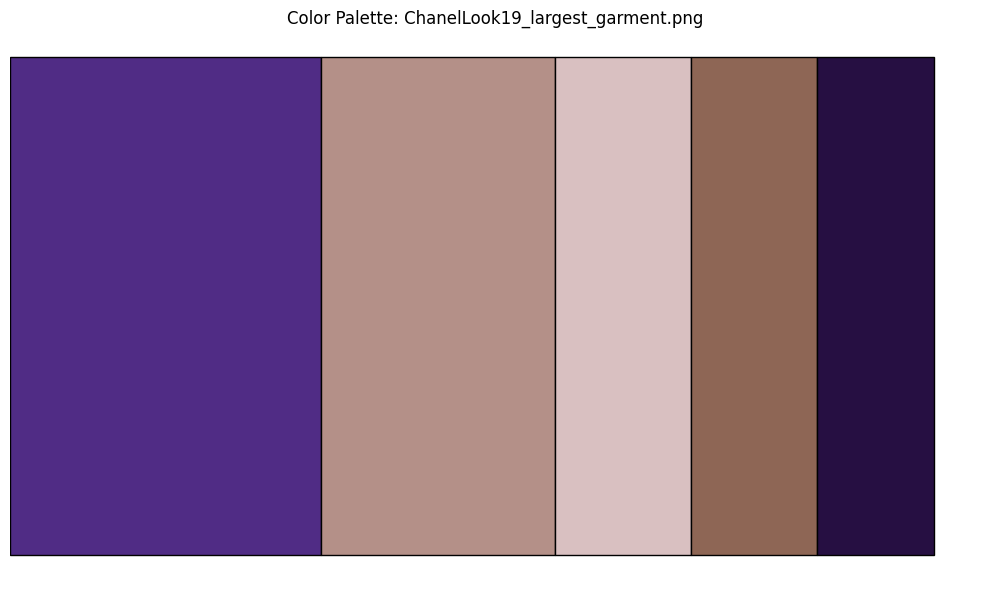

In [3]:
# --------- MAIN BLOCK ---------
# Path to the image
image_path = "/Users/user/Desktop/Project Submission/Implementation/Source Code/Source Code/project 2/public/images/ProcessedRunwayImages/ChanelLook19_largest_garment.png"
num_colors = 5  # Number of dominant colors to extract

# Check if the image exists
if not os.path.exists(image_path):
    print(f"Error: The image at {image_path} doesn't exist.")
else:
    print(f"Extracting colors from: {image_path}")
    colors, percentages = extract_colors(image_path, num_colors)

    if colors is not None and percentages is not None:
        print(f"Colors: {colors}")
        print(f"Percentages: {percentages}")

        # Show color palette for the image
        visualize_colors(colors, percentages, os.path.basename(image_path))
    else:
        print("No colors found in the image.")